In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Now that the datasets are read lets take a little look at what we have

In [2]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Now how about a little Exploritory Data Analysis**

In [4]:
# We will view the data types of each column
print(df_train.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [5]:
# Now lets check out the summary statistics of the numerical columns
print(df_train.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


*A little look for missing values*

In [6]:
# Check for missing values
print(df_train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


*The Cabin attribute has far to many missing values, lets get rid of it.*

In [7]:
df_train.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

*Now I think we should fill in the missing agees with the median.*

In [8]:
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
df_test['Age'].fillna(df_test['Age'].median(), inplace=True)

*How about for the missng embark we use the most common values (the mean).*

In [12]:
mode = df_train['Embarked'].mode()[0]
df_train['Embarked'].fillna(mode, inplace=True)

*Now since the 'Sibsp' & the 'Parch' have to do with family, lets combine them into a Family attribute*

In [13]:
df_train['Family'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family'] = df_test['SibSp'] + df_test['Parch'] + 1

*While we are at it, lets create a 'IsAlone' attribute on whether the passenger is traveling alone.*

In [15]:
df_train['IsAlone'] = np.where(df_train['Family'] == 1, 1, 0)
df_test['IsAlone'] = np.where(df_test['Family'] == 1, 1, 0)

*Why don't we add a new 'Title' feature by extracting passenger's titles from thier name.*

In [16]:
df_train['Title'] = df_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df_test['Title'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

*Let’s replace some Titles,  we will have a 'Rare' for unusual Titles, and combine similar ones.*

In [17]:
# Replace rare titles with 'Rare' and combine similar titles
df_train['Title'] = df_train['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_train['Title'] = df_train['Title'].replace('Mlle', 'Miss')
df_train['Title'] = df_train['Title'].replace('Ms', 'Miss')
df_train['Title'] = df_train['Title'].replace('Mme', 'Mrs')

df_test['Title'] = df_test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_test['Title'] = df_test['Title'].replace('Mlle', 'Miss')
df_test['Title'] = df_test['Title'].replace('Ms', 'Miss')
df_test['Title'] = df_test['Title'].replace('Mme', 'Mrs')

*Next, let's map categorical features to numerical values*

In [18]:
sex_mapping = {'male': 0, 'female': 1}
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
df_train['Sex'] = df_train['Sex'].map(sex_mapping)
df_train['Embarked'] = df_train['Embarked'].map(embarked_mapping)
df_train['Title'] = df_train['Title'].map(title_mapping)

*A little more maping*

In [19]:
df_test['Sex'] = df_test['Sex'].map(sex_mapping)
df_test['Embarked'] = df_test['Embarked'].map(embarked_mapping)
df_test['Title'] = df_test['Title'].map(title_mapping)

*For the next Step let's produce some visualizations*

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

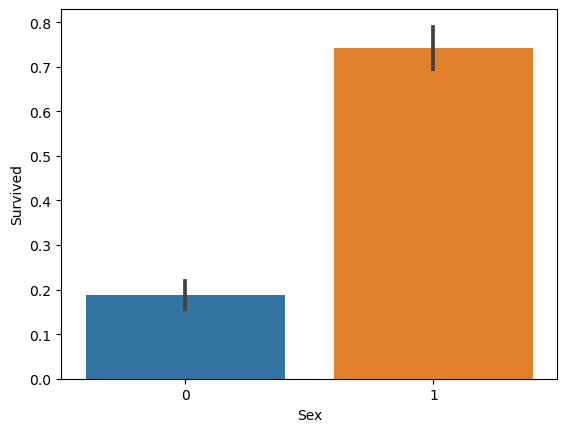

In [21]:
sns.barplot(x='Sex', y='Survived', data=df_train)
plt.show()

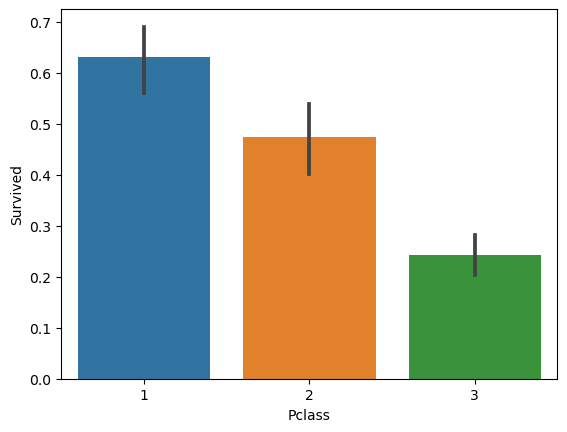

In [22]:
# Bar chart of survival rates by passenger class
sns.barplot(x='Pclass', y='Survived', data=df_train)
plt.show()

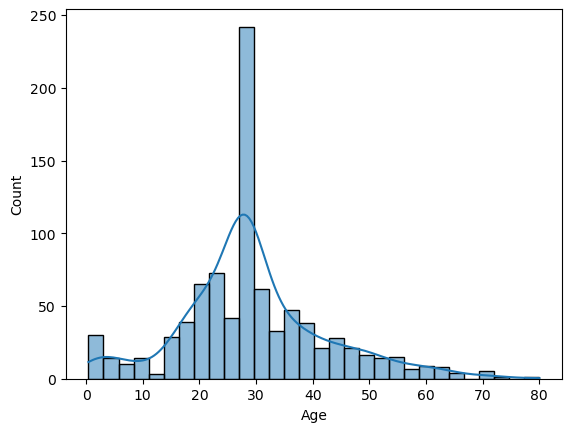

In [23]:
# Histogram of passenger ages
sns.histplot(data=df_train, x='Age', kde=True)
plt.show()

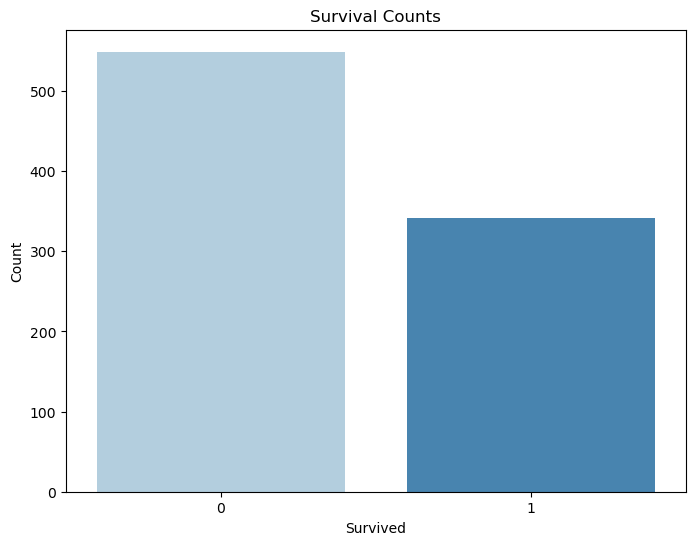

In [25]:
# Create bar chart of survival counts
survived_counts = df_train['Survived'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=survived_counts.index, y=survived_counts.values, palette='Blues')
plt.title('Survival Counts')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

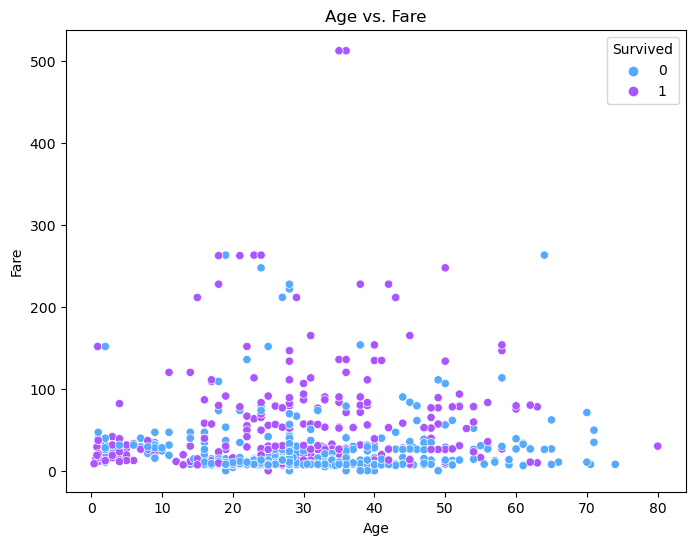

In [28]:
# Create scatter plot of age vs. fare
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=df_train, palette='cool')
plt.title('Age vs. Fare')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.show()